In [94]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import re
import random

from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler,MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, train_test_split, train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from scipy import stats
import statsmodels.api as sm
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

## Data preprocessing

The first objective is to adequeately process the datasets so as to make the later analysis conveninent

In [95]:
data_train = pd.read_csv("loan_def_train.csv")
data_test = pd.read_csv("loan_def_test.csv")

In [96]:
data_train.head()

,Id,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [97]:
data_train["Purpose"].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

## Feature engineering

From the frequency count of the Purpose feature, it can be noted that certain values have a similarity in literal sense. As such, it would be helpful to introduce a new column with a reduced number of feature values, by grouping similar features together.

In [98]:
# Based on common understanding, we define three categories comprising each of the feature initially present in the datasets

Recreation= ["take a trip", "vacation", "wedding", "moving"]
Expense = ["medical bills", "educational expenses", "home improvements"]
Loan_Debt = ["debt consolidation", "business loan", "small business", "major purchase"]
Personal = ["buy a car", "buy house", "renewable energy"]
Other = ["other"]

In [99]:
data_test["Purpose"].value_counts()

debt consolidation      1973
other                    240
home improvements        140
buy a car                 34
business loan             30
medical bills             27
buy house                 19
take a trip               14
major purchase             9
small business             5
vacation                   3
educational expenses       3
wedding                    2
moving                     1
Name: Purpose, dtype: int64

In [100]:
def label_purpose(row):
    if row["Purpose"] in Recreation:
        return "Recreation"
    if row["Purpose"] in Expense:
        return "Expense"
    if row["Purpose"] in Loan_Debt:
        return "Loan_Debt"
    if row["Purpose"] in Personal:
        return "Personal"
    if row["Purpose"] in Other:
        return "other"
    

data_train["Purpose_label"] = data_train.apply(lambda row: label_purpose(row), axis = 1)


In [101]:
data_train.drop("Purpose", axis=1, inplace=True)

In [102]:
data_test["Purpose_label"] = data_test.apply(lambda row: label_purpose(row), axis =1)
data_test.drop("Purpose", axis=1, inplace=True)

data_test.columns

Index(['Id', 'Home Ownership', 'Annual Income', 'Years in current job',
       'Tax Liens', 'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Purpose_label'],
      dtype='object')

In [103]:
# The training and test data are modified such that only the relevant information is present

Id = data_test["Id"]
data_test.drop("Id", axis=1, inplace=True)
y_tr = data_train["Credit Default"]
data_train.drop(["Credit Default", "Id"], axis=1, inplace=True)


In [104]:
# A rough overview to understand the datatypes of each column and no. of null values

data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Term                          7500 non-null   object 
 11  Current Loan Amount           7500 non-null   float64
 12  Current Credit Balance        7500 non-null   float64
 13  Mon

In [105]:
data_train.isnull().sum(axis=0)

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Purpose_label                      0
dtype: int64

In [106]:
data_test.isnull().sum(axis = 0)

Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
Purpose_label                      0
dtype: int64

In [107]:
data_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000


Considering the relationship between different numerical feature, we define two additional features that supposedly provides valuable information. In particular, the financial status of a person which can be arguably considered as a strong factor for the given problem, is well understood through the monthly amount a person has in hand and debt to be resolved.

In [108]:
data_train["Monthly_amount_left"] =  data_train["Annual Income"]/12 - data_train["Monthly Debt"]
data_train["Residual_debt"] =  data_train["Current Loan Amount"] - data_train["Current Credit Balance"]

data_test["Monthly_amount_left"] =  data_train["Annual Income"]/12 - data_train["Monthly Debt"]
data_test["Residual_debt"] =  data_train["Current Loan Amount"] - data_train["Current Credit Balance"]

Median income  1366391.7201749957


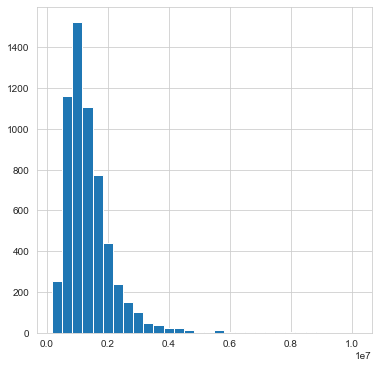

In [109]:
# Since, the "annual income" column has a highly skewed distribution, we replace the null values by the median

plt.figure(figsize=(6,6))
plt.hist(data_train["Annual Income"], bins=30)
print("Median income ", data_train["Annual Income"].mean())

### Filling missing values

In [110]:
# Filling the missing values

data_train["Annual Income"].fillna((data_train["Annual Income"].median()), inplace= True)
data_train["Years in current job"].fillna((data_train["Years in current job"].value_counts().index[2]), inplace= True)
data_train["Credit Score"].fillna((data_train["Credit Score"].median()), inplace= True)
data_train["Bankruptcies"].fillna(data_train["Bankruptcies"].mean(), inplace= True)
data_train["Months since last delinquent"].fillna(data_train["Months since last delinquent"].mean(), inplace= True)
data_train["Monthly_amount_left"].fillna(data_train["Monthly_amount_left"].median(), inplace= True)

In [111]:
data_test["Annual Income"].fillna((data_test["Annual Income"].median()), inplace= True)
data_test["Years in current job"].fillna((data_test["Years in current job"].value_counts().index[2]), inplace= True)
data_test["Credit Score"].fillna((data_test["Credit Score"].median()), inplace= True)
data_test["Bankruptcies"].fillna(data_test["Bankruptcies"].median(), inplace= True)
data_test["Months since last delinquent"].fillna(data_test["Months since last delinquent"].mean(), inplace= True)
data_test["Monthly_amount_left"].fillna(data_train["Monthly_amount_left"].median(), inplace= True)

In [112]:
# The column "Months sunce last delinquent" has more than 50% null values, which could be erroneous to naively replace. 
#Hence, we drop this column

data_train.drop("Months since last delinquent", axis=1, inplace= True)
data_test.drop("Months since last delinquent", axis=1, inplace= True)

In [113]:
# All null values are removed.

print(data_train.isnull().sum().sum())
print(data_test.isnull().sum().sum())

0
0


It would also be helpful to have the number of years in current job as a numerical feature.

In [114]:
data_train["Years in current job"].value_counts().index.tolist()

['10+ years',
 '3 years',
 '2 years',
 '< 1 year',
 '5 years',
 '1 year',
 '4 years',
 '6 years',
 '7 years',
 '8 years',
 '9 years']

In [115]:
# Modify volumn values of years of job

lst_1 = data_train["Years in current job"].value_counts().index.tolist()
lst_2 = [10,3,2,0.5,5, 1,6,7,2,8,9]
data_train["Years in current job"] = data_train["Years in current job"].replace(lst_1, lst_2)
data_train["Years in current job"].dtypes

dtype('float64')

In [116]:
lst_1 = data_test["Years in current job"].value_counts().index.tolist()
lst_2 = [10,2,3,0.5,5, 1,4,7,6,8,9]
data_test["Years in current job"] = data_test["Years in current job"].replace(lst_1, lst_2)


In [117]:
# Separate list of numerical and categorical features

tr_num = data_train.select_dtypes(include = ["int", "float"]).columns.to_list()
tr_cat = data_train.select_dtypes(include = ["object"]).columns.to_list()
test_num = data_test.select_dtypes(include = ["int", "float"]).columns.to_list()
test_cat = data_test.select_dtypes(include = ["object"]).columns.to_list()

In [118]:
data_train_num = data_train[tr_num]
data_train_cat = data_train[tr_cat]
data_test_num = data_test[test_num]
data_test_cat = data_test[test_cat]

## EDA to understand categorical features

E:\Anaconda_main\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


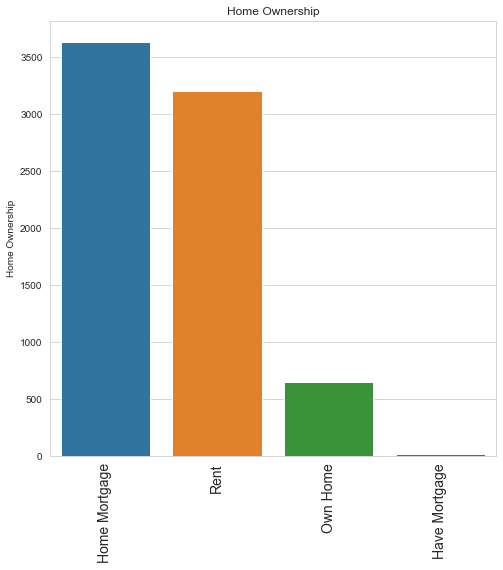

E:\Anaconda_main\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


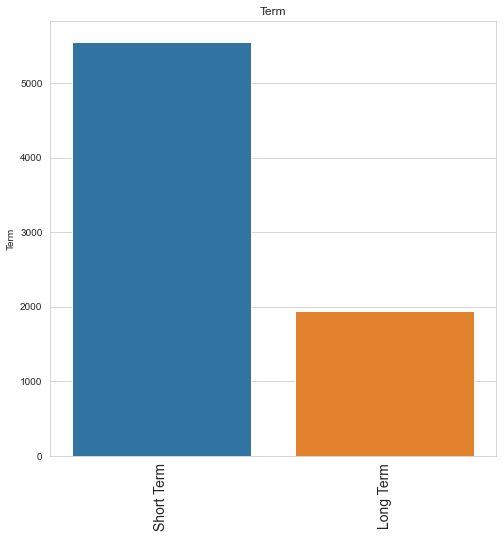

E:\Anaconda_main\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


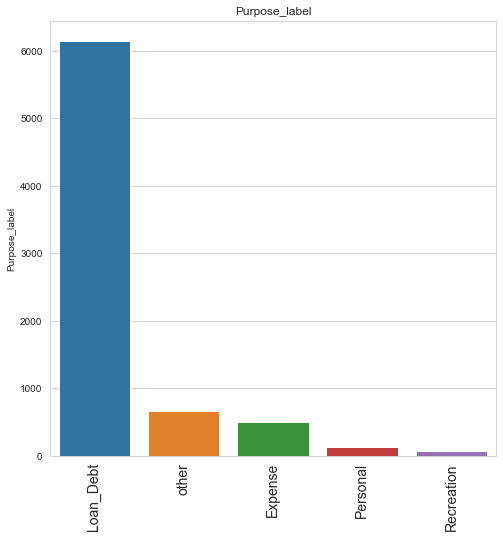

In [119]:
for i in data_train_cat.columns:
    plt.figure(figsize=(8,8))
    sns.barplot(data_train_cat[i].value_counts().index, data_train_cat[i].value_counts()).set_title(i)
    plt.xticks(fontsize=14, rotation = "vertical")
    plt.show()

In order to prevent any multicollinearity, it would be helpful to analyse the numerical features through their correlation coefficients and modify the datasets accordingly.

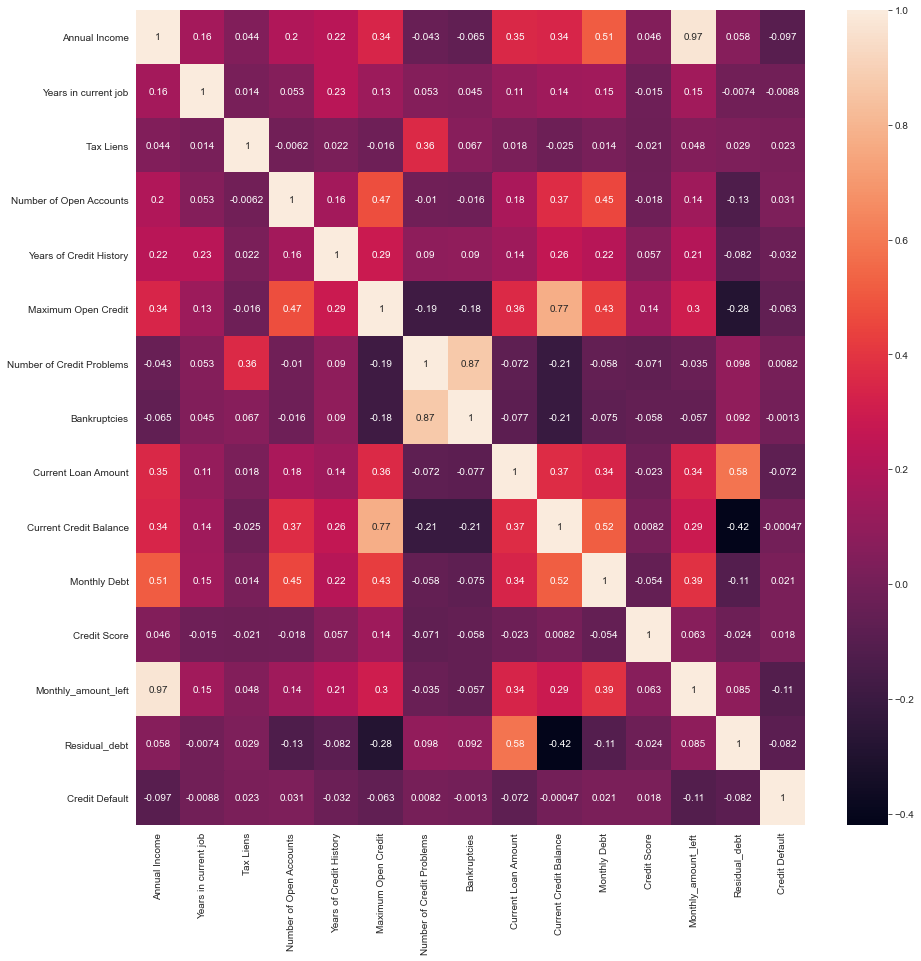

In [120]:
# The full dataset including the target feature is prepared

all_data = data_train.copy()
all_data["Credit Default"] =  y_tr

corrmat = all_data.corr(method = "spearman")
plt.figure(figsize=(15,15))
#plot heat map
g=sns.heatmap(corrmat,annot=True)

It is obvious that certain features have high inter-correlation which could be undesirable in the model training stage.

In [121]:
# The redundant columns are removed

cols_to_drop = ["Annual Income", "Monthly Debt", "Current Credit Balance", "Current Loan Amount"]

data_train.drop(cols_to_drop, axis=1, inplace=True)
data_test.drop(cols_to_drop, axis=1, inplace=True)

In [122]:
data_train.columns

Index(['Home Ownership', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems', 'Bankruptcies',
       'Term', 'Credit Score', 'Purpose_label', 'Monthly_amount_left',
       'Residual_debt'],
      dtype='object')

In [123]:
data_test.columns

Index(['Home Ownership', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems', 'Bankruptcies',
       'Term', 'Credit Score', 'Purpose_label', 'Monthly_amount_left',
       'Residual_debt'],
      dtype='object')

In [124]:
for col in cols_to_drop:
    tr_num.remove(col)
    test_num.remove(col)
    
print(tr_num)
print(test_num)

['Years in current job', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 'Bankruptcies', 'Credit Score', 'Monthly_amount_left', 'Residual_debt']
['Years in current job', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 'Bankruptcies', 'Credit Score', 'Monthly_amount_left', 'Residual_debt']


The statistical distribution of all the numerical features can be studied

E:\Anaconda_main\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


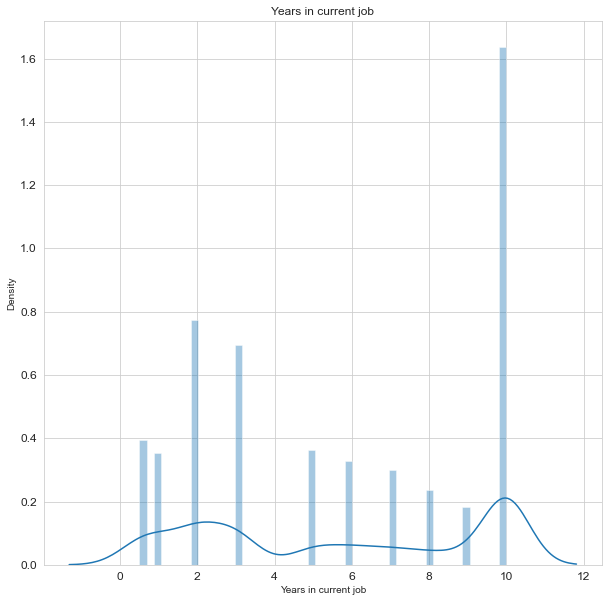

The skewness is  -0.014763770675786842


E:\Anaconda_main\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


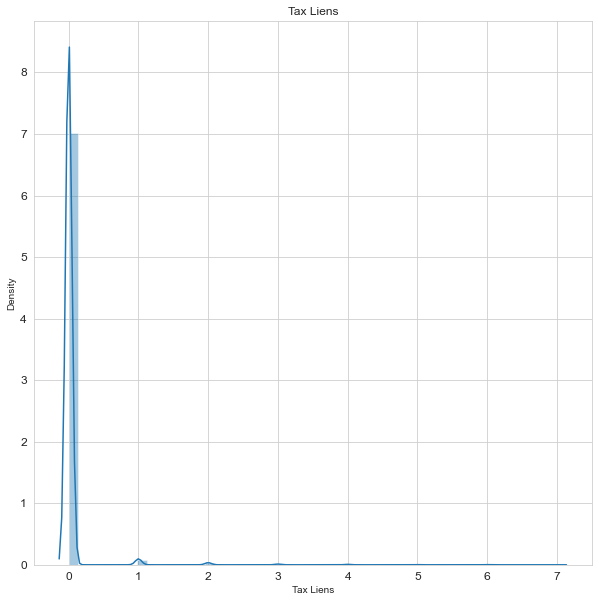

The skewness is  12.991269746435778


E:\Anaconda_main\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


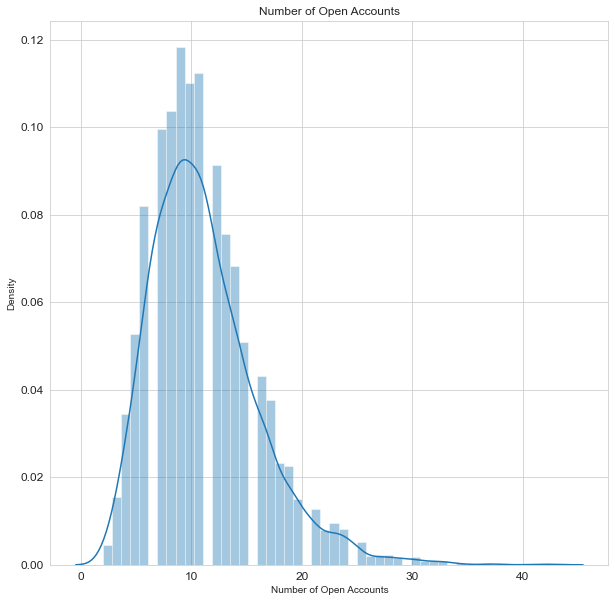

The skewness is  1.1174600466297433


E:\Anaconda_main\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


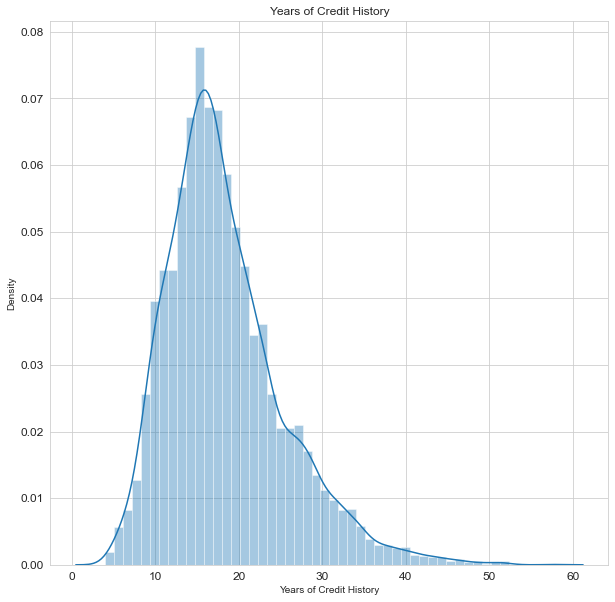

The skewness is  1.0464429620560196


E:\Anaconda_main\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


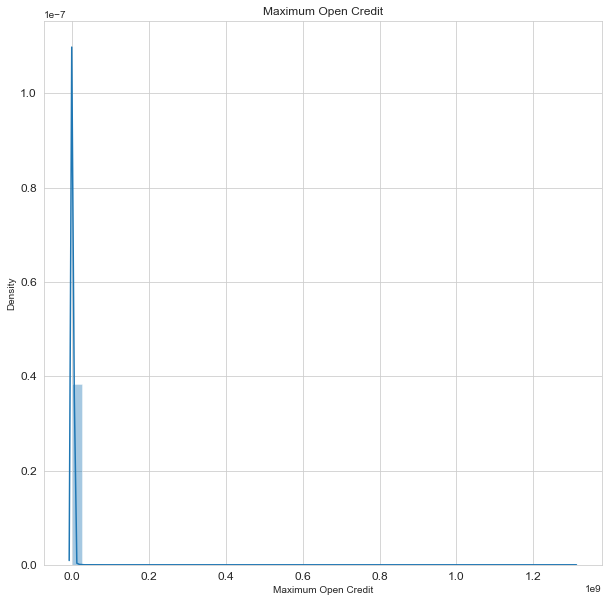

The skewness is  74.17937573472186


E:\Anaconda_main\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


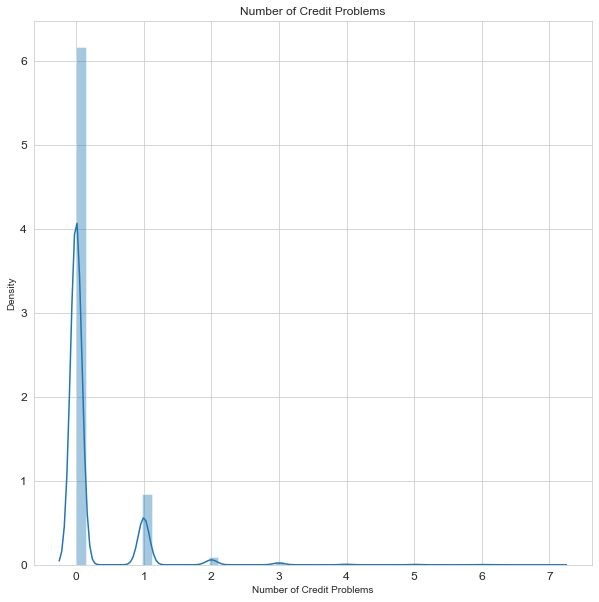

The skewness is  4.563332353698451


E:\Anaconda_main\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


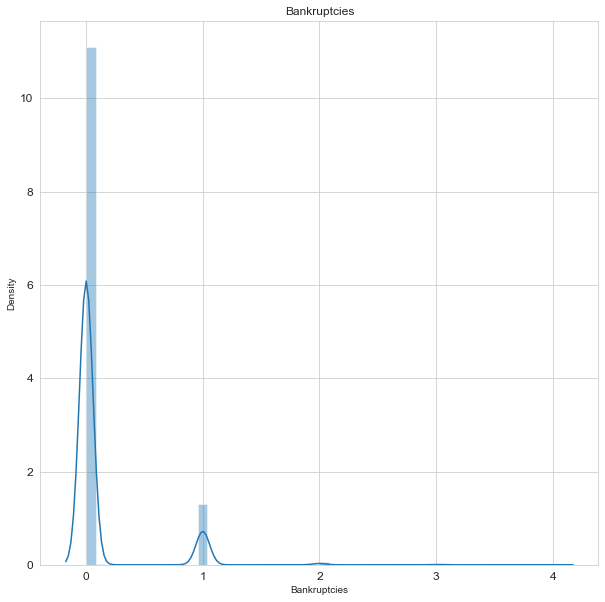

The skewness is  3.2653217613078365


E:\Anaconda_main\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


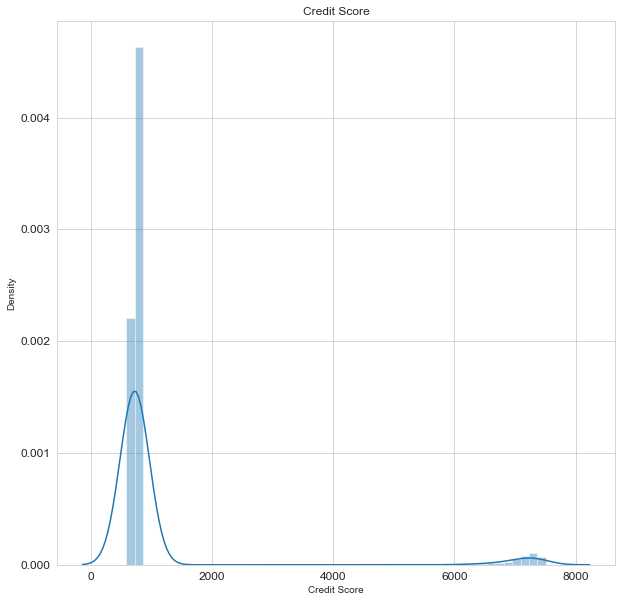

The skewness is  3.989302544627795


E:\Anaconda_main\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


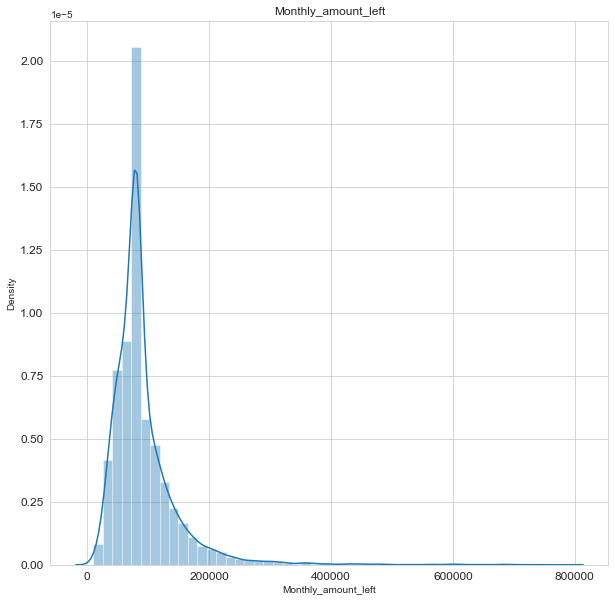

The skewness is  3.8646433120469763


E:\Anaconda_main\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


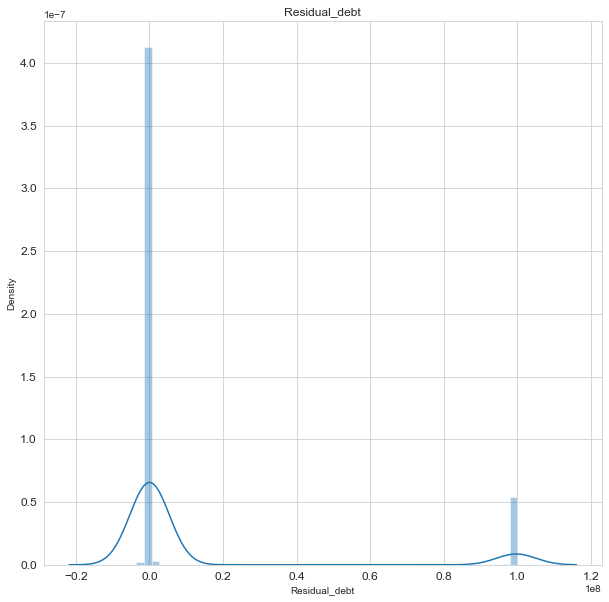

The skewness is  2.3980185015954363


In [125]:
from scipy.stats import skew

for fea in tr_num:
    plt.figure(figsize=(10,10))
    sns.set_style('whitegrid')
    sns.distplot(data_train[fea], kde=True, bins= 50)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(fea)
    plt.show()
    print("The skewness is ", skew(data_train[fea]))
    

In [126]:
# Copy of original training and test dataset

X_tr =  data_train.copy()
X_ts =  data_test.copy()

## Outlier treatment

E:\Anaconda_main\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


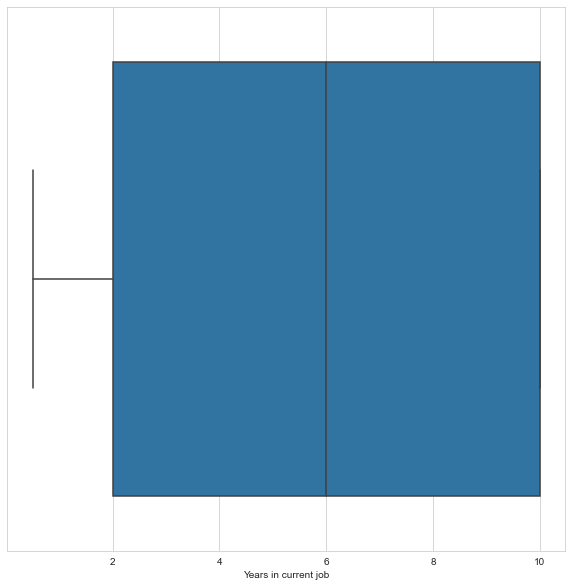

E:\Anaconda_main\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


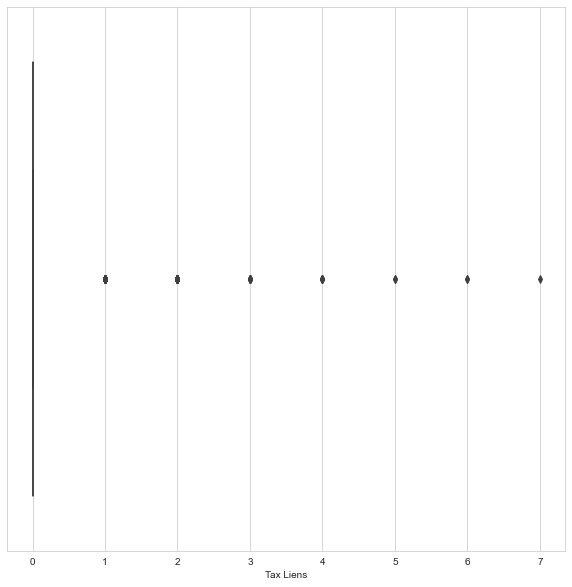

E:\Anaconda_main\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


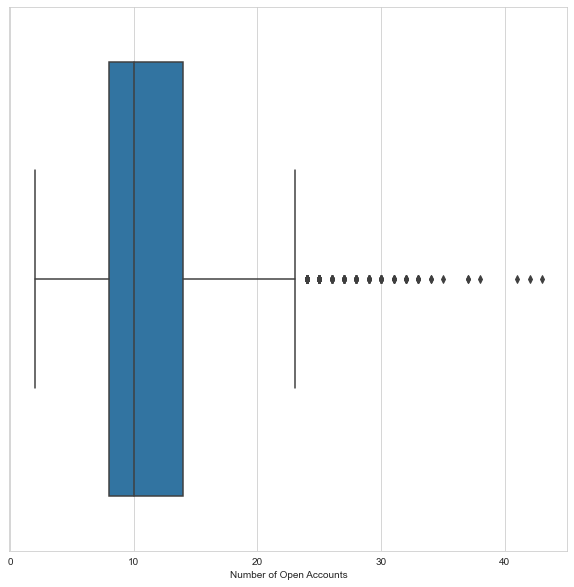

E:\Anaconda_main\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


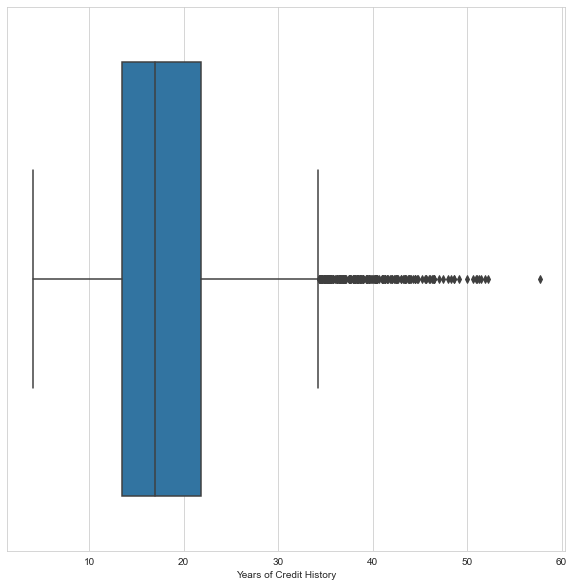

E:\Anaconda_main\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


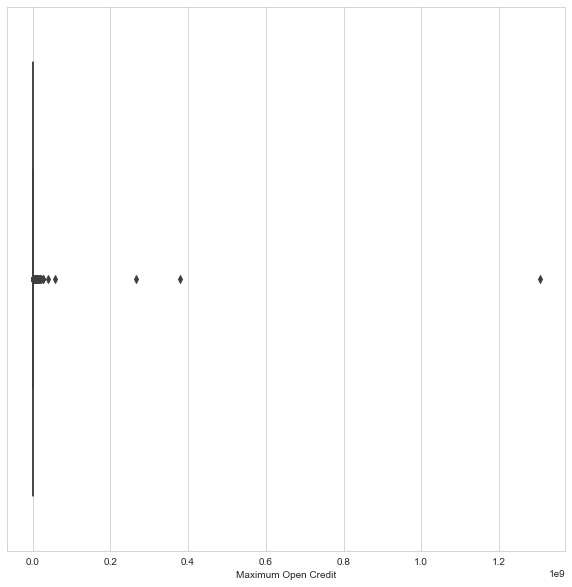

E:\Anaconda_main\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


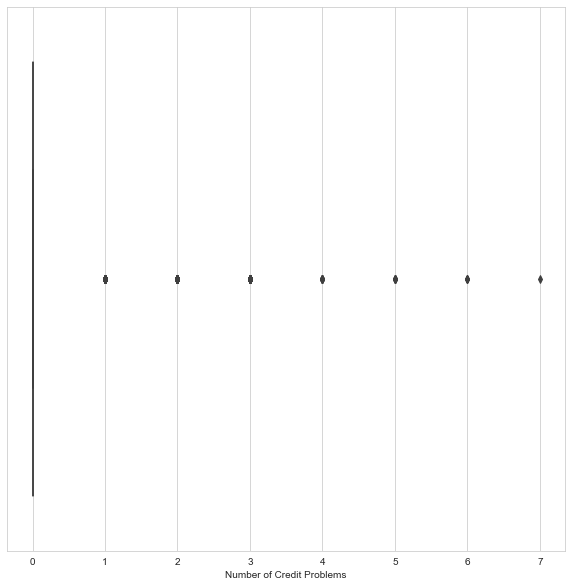

E:\Anaconda_main\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


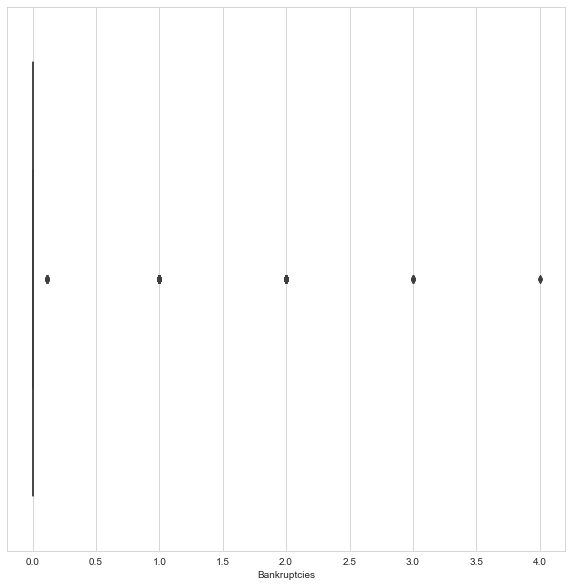

E:\Anaconda_main\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


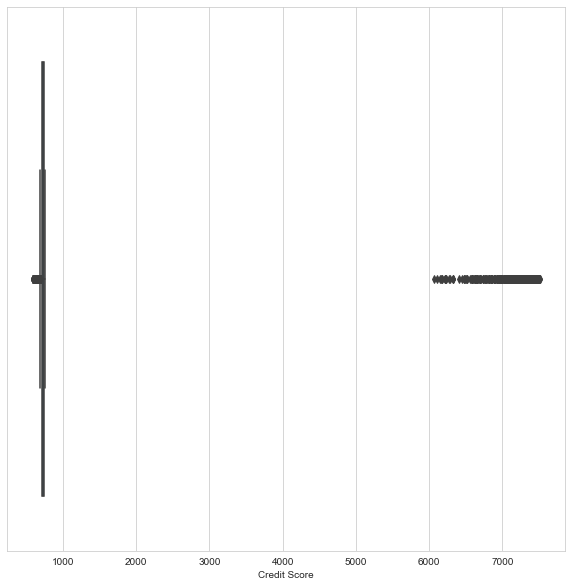

E:\Anaconda_main\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


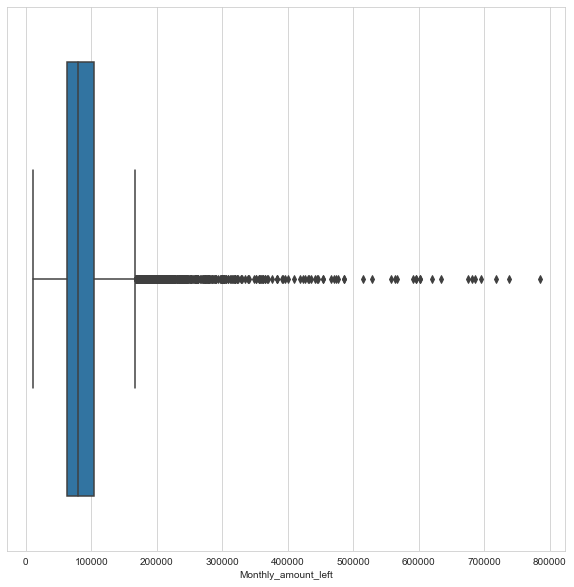

E:\Anaconda_main\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


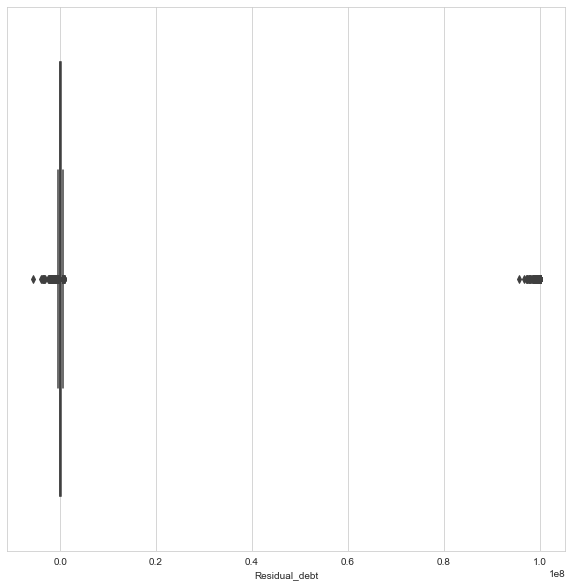

In [127]:
for fea in tr_num:
    plt.figure(figsize=(10,10))
    sns.boxplot(data_train[fea])
    plt.show()
    


### Interquartile range method

We notice that there are a significant number of outliers for each feature in the data set, which can negatively impact our predictions. As such, the outliers have to be appropriately imputed using the IQR approach.

In [128]:
Q1_ai =  data_train["Residual_debt"].quantile(0.25)
Q3_ai =  data_train["Residual_debt"].quantile(0.75)

iqr_ai = Q3_ai - Q1_ai

up_lim_ai = Q3_ai + 1.5*iqr_ai
low_lim_ai = Q1_ai - 1.5*iqr_ai


Q1_cs =  data_train["Credit Score"].quantile(0.25)
Q3_cs =  data_train["Credit Score"].quantile(0.75)

iqr_cs = Q3_cs - Q1_cs

up_lim_cs = Q3_cs + 1.5*iqr_cs
low_lim_cs = Q1_cs - 1.5*iqr_cs

Q1_md =  data_train["Monthly_amount_left"].quantile(0.25)
Q3_md =  data_train["Monthly_amount_left"].quantile(0.75)

iqr_md = Q3_md - Q1_md

up_lim_md = Q3_md + 1.5*iqr_md
low_lim_md = Q1_md - 1.5*iqr_md

Q1_cp =  data_train["Number of Credit Problems"].quantile(0.25)
Q3_cp =  data_train["Number of Credit Problems"].quantile(0.75)

iqr_cp = Q3_cp - Q1_cp

up_lim_cp = Q3_cp + 1.5*iqr_cp
low_lim_cp = Q1_cp - 1.5*iqr_cp

Q1_tl =  data_train["Tax Liens"].quantile(0.25)
Q3_tl =  data_train["Tax Liens"].quantile(0.75)

iqr_tl = Q3_tl - Q1_tl

up_lim_tl = Q3_tl + 1.5*iqr_tl
low_lim_tl = Q1_tl - 1.5*iqr_tl

Q1_mc =  data_train["Maximum Open Credit"].quantile(0.25)
Q3_mc =  data_train["Maximum Open Credit"].quantile(0.75)

iqr_mc = Q3_mc - Q1_mc

up_lim_mc = Q3_mc + 1.5*iqr_mc
low_lim_mc = Q1_mc - 1.5*iqr_mc

Q1_oa =  data_train["Number of Open Accounts"].quantile(0.25)
Q3_oa =  data_train["Number of Open Accounts"].quantile(0.75)

iqr_oa = Q3_oa - Q1_oa

up_lim_oa = Q3_oa + 1.5*iqr_oa
low_lim_oa = Q1_oa - 1.5*iqr_oa

Q1_ch =  data_train["Years of Credit History"].quantile(0.25)
Q3_ch =  data_train["Years of Credit History"].quantile(0.75)

iqr_ch = Q3_ch - Q1_ch

up_lim_ch = Q3_ch + 1.5*iqr_ch
low_lim_ch = Q1_ch - 1.5*iqr_ch


c1 = data_train["Residual_debt"] > up_lim_ai
c10 = data_train["Residual_debt"] < low_lim_ai
c2 = data_train["Credit Score"] < low_lim_cs
c3 = data_train["Credit Score"] > up_lim_cs
c4 = data_train["Monthly_amount_left"] > up_lim_md
c5 = data_train["Number of Credit Problems"] > 4
c6 = data_train["Tax Liens"] > 5
c7 = data_train["Maximum Open Credit"] > up_lim_mc
c8 = data_train["Number of Open Accounts"] > up_lim_oa
c9 = data_train["Years of Credit History"] > up_lim_ch



In [129]:
Q1_ai_t =  data_test["Residual_debt"].quantile(0.25)
Q3_ai_t =  data_test["Residual_debt"].quantile(0.75)

iqr_ai_t = Q3_ai_t - Q1_ai_t

up_lim_ai_t = Q3_ai_t + 1.5*iqr_ai_t
low_lim_ai_t = Q1_ai_t - 1.5*iqr_ai_t

Q1_cs_t =  data_test["Credit Score"].quantile(0.25)
Q3_cs_t =  data_test["Credit Score"].quantile(0.75)

iqr_cs_t = Q3_cs_t - Q1_cs_t

up_lim_cs_t = Q3_cs_t + 1.5*iqr_cs_t
low_lim_cs_t = Q1_cs_t - 1.5*iqr_cs_t

Q1_md_t =  data_test["Monthly_amount_left"].quantile(0.25)
Q3_md_t =  data_test["Monthly_amount_left"].quantile(0.75)

iqr_md_t = Q3_md_t - Q1_md_t

up_lim_md_t = Q3_md_t + 1.5*iqr_md_t
low_lim_md_t = Q1_md_t - 1.5*iqr_md_t

Q1_cp_t =  data_test["Number of Credit Problems"].quantile(0.25)
Q3_cp_t =  data_train["Number of Credit Problems"].quantile(0.75)

iqr_cp_t = Q3_cp_t - Q1_cp_t

up_lim_cp_t = Q3_cp_t + 1.5*iqr_cp_t
low_lim_cp_t = Q1_cp_t - 1.5*iqr_cp_t

Q1_tl_t =  data_test["Tax Liens"].quantile(0.25)
Q3_tl_t =  data_test["Tax Liens"].quantile(0.75)

iqr_tl_t = Q3_tl_t - Q1_tl_t

up_lim_tl_t = Q3_tl_t + 1.5*iqr_tl_t
low_lim_tl_t = Q1_tl - 1.5*iqr_tl_t

Q1_mc_t =  data_test["Maximum Open Credit"].quantile(0.25)
Q3_mc_t =  data_test["Maximum Open Credit"].quantile(0.75)

iqr_mc_t = Q3_mc_t

up_lim_mc_t = Q3_mc_t + 1.5*iqr_mc_t
low_lim_mc_t = Q1_mc_t - 1.5*iqr_mc_t

Q1_oa_t =  data_test["Number of Open Accounts"].quantile(0.25)
Q3_oa_t = data_test["Number of Open Accounts"].quantile(0.75)

iqr_oa_t = Q3_oa_t - Q1_oa_t

up_lim_oa_t = Q3_oa_t + 1.5*iqr_oa_t
low_lim_oa_t = Q1_oa_t - 1.5*iqr_oa_t

Q1_ch_t =  data_test["Years of Credit History"].quantile(0.25)
Q3_ch_t =  data_test["Years of Credit History"].quantile(0.75)

iqr_ch_t = Q3_ch_t - Q1_ch_t

up_lim_ch_t = Q3_ch_t + 1.5*iqr_ch_t
low_lim_ch_t = Q1_ch_t - 1.5*iqr_ch_t

c1_t= data_test["Residual_debt"] > up_lim_ai_t
c10_t= data_test["Residual_debt"] < low_lim_ai_t
c2_t = data_test["Credit Score"] < low_lim_cs_t
c3_t = data_test["Credit Score"] > up_lim_cs_t
c4_t= data_test["Monthly_amount_left"] > up_lim_md_t
c5_t = data_test["Number of Credit Problems"] > 4
c6_t = data_test["Tax Liens"] > 5
c7_t = data_test["Maximum Open Credit"] > up_lim_mc_t
c8_t = data_test["Number of Open Accounts"] > up_lim_oa_t
c9_t = data_test["Years of Credit History"] > up_lim_ch_t



In [130]:
X_tr.loc[c1, "Residual_debt"] = up_lim_ai
X_tr.loc[c10, "Residual_debt"] = low_lim_ai
X_tr.loc[c2, "Credit Score"]  = low_lim_cs
X_tr.loc[c3, "Credit Score"] =  up_lim_cs 
X_tr.loc[c4, "Monthly_amount_left"] =  up_lim_md
X_tr.loc[c7, "Maximum Open Credit"] = up_lim_mc
X_tr.loc[c8, "Number of Open Accounts"] = up_lim_oa
X_tr.loc[c9, "Years of Credit History"] = up_lim_ch


In [131]:
X_ts.loc[c1_t, "Residual_debt"] = up_lim_ai_t
X_ts.loc[c10_t, "Residual_debt"] = low_lim_ai_t
X_ts.loc[c2_t, "Credit Score"]  = low_lim_cs_t
X_ts.loc[c3_t, "Credit Score"] =   up_lim_cs_t 
X_ts.loc[c4_t, "Monthly_amount_left"] =  up_lim_md_t
X_ts.loc[c7_t, "Maximum Open Credit"] = up_lim_mc_t
X_ts.loc[c8_t, "Number of Open Accounts"] = up_lim_oa_t
X_ts.loc[c9_t, "Years of Credit History"] = up_lim_ch_t


We can now visualise the affect of outlier tratment in the boxplot

E:\Anaconda_main\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


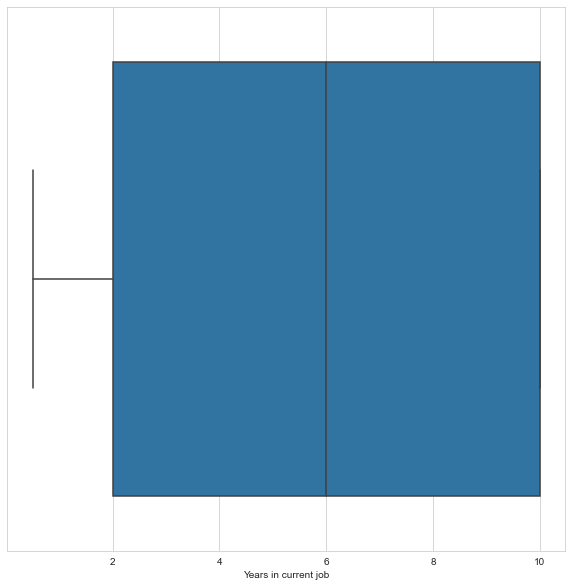

E:\Anaconda_main\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


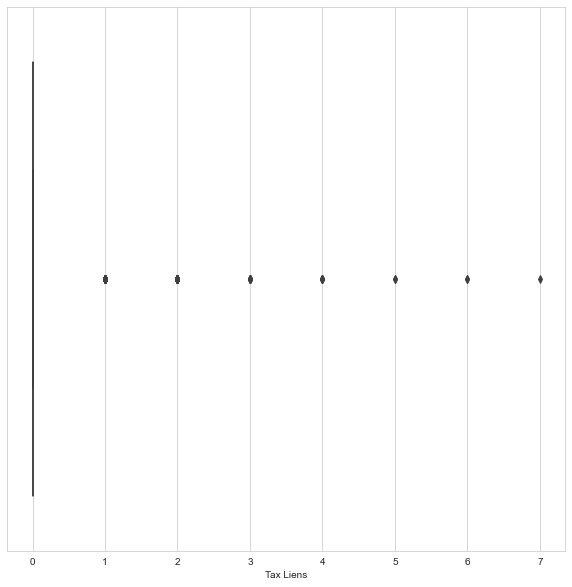

E:\Anaconda_main\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


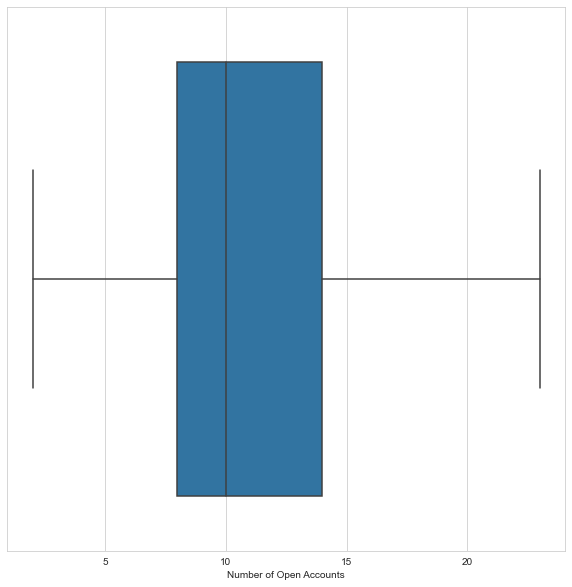

E:\Anaconda_main\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


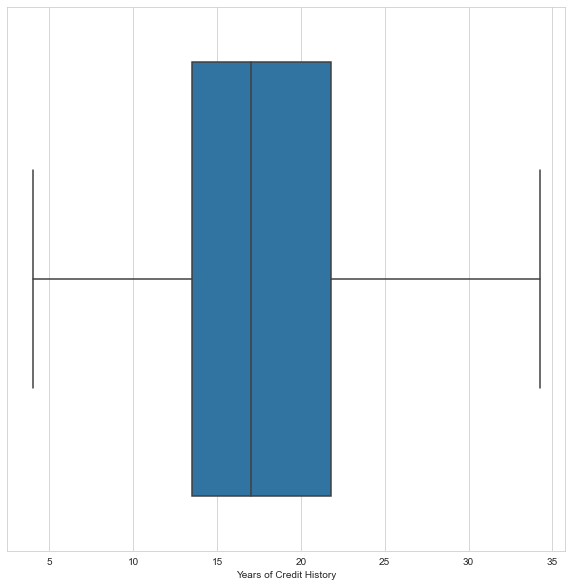

E:\Anaconda_main\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


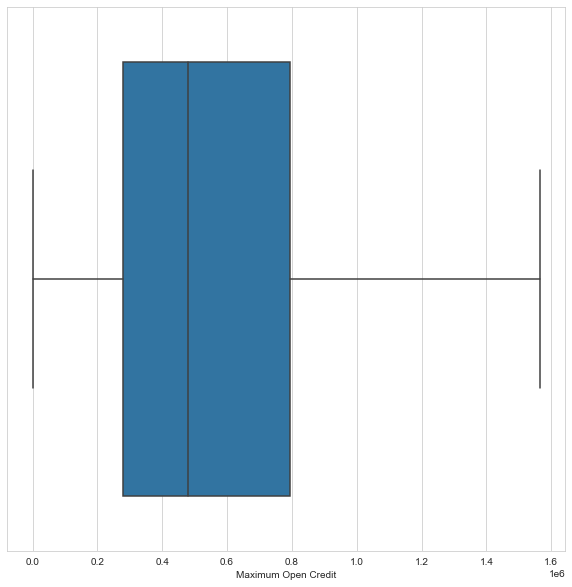

E:\Anaconda_main\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


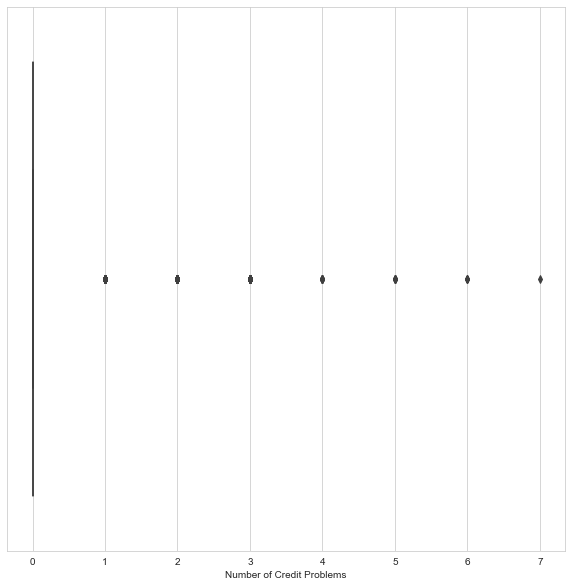

E:\Anaconda_main\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


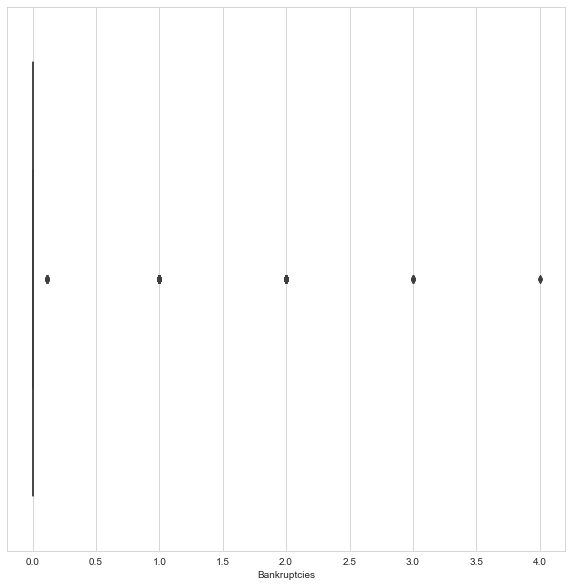

E:\Anaconda_main\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


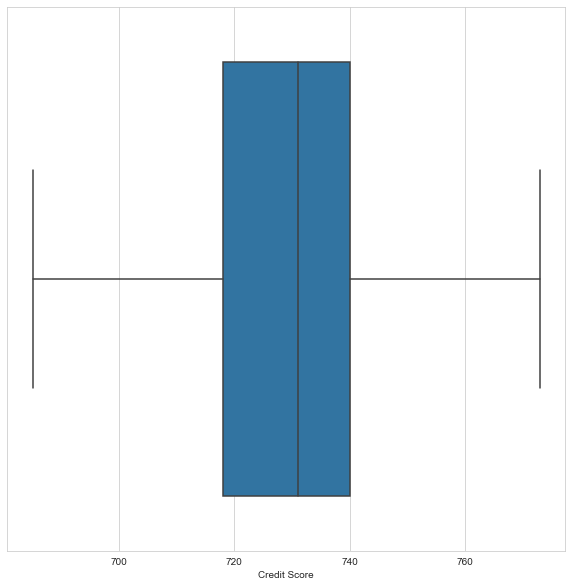

E:\Anaconda_main\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


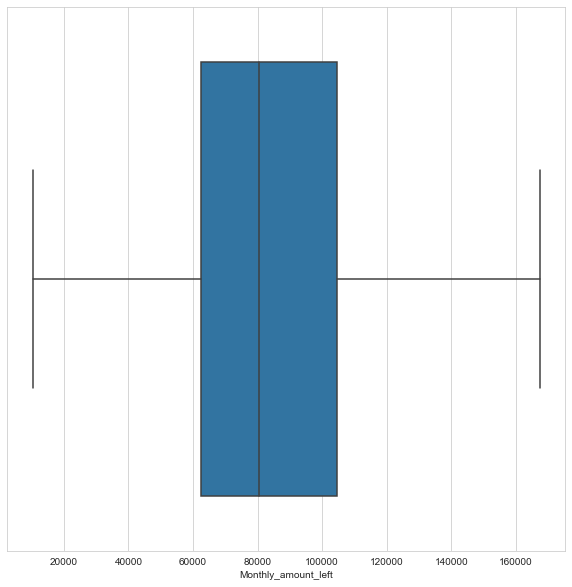

E:\Anaconda_main\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


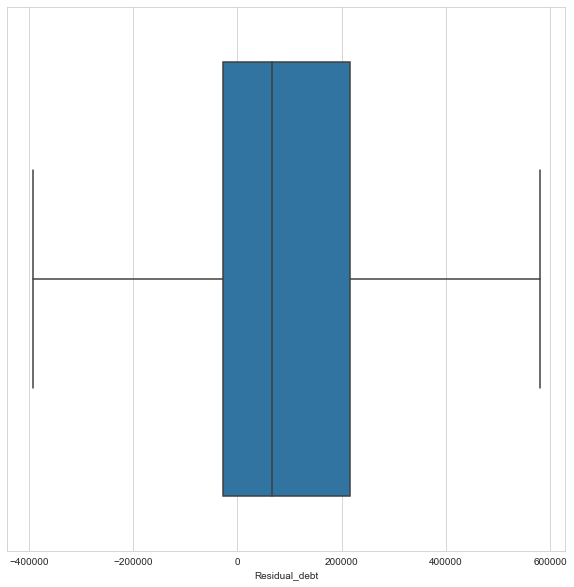

In [132]:

for fea in tr_num:
    plt.figure(figsize=(10,10))
    sns.boxplot(X_tr[fea])
    plt.show()
    

E:\Anaconda_main\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


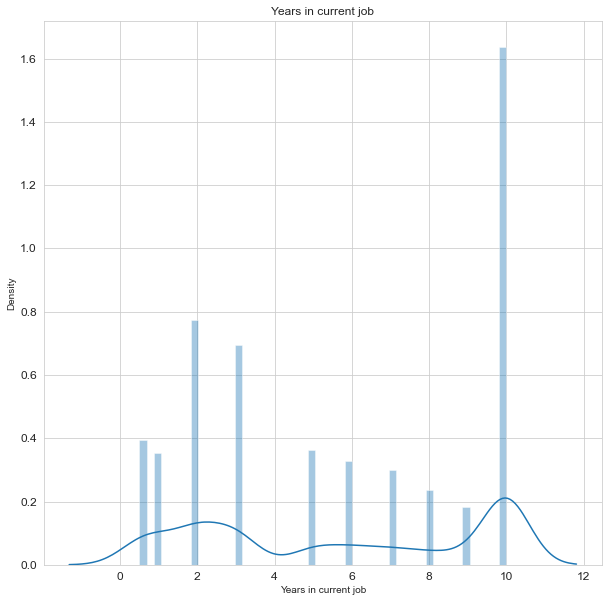

The skewness is  -0.014763770675786842


E:\Anaconda_main\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


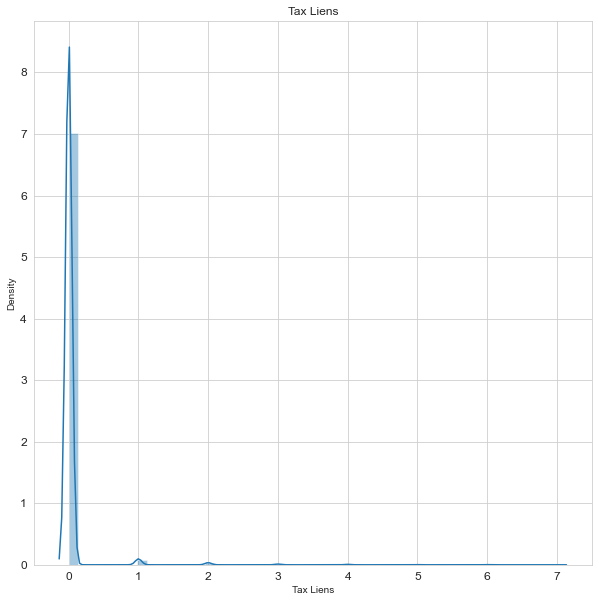

The skewness is  12.991269746435778


E:\Anaconda_main\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


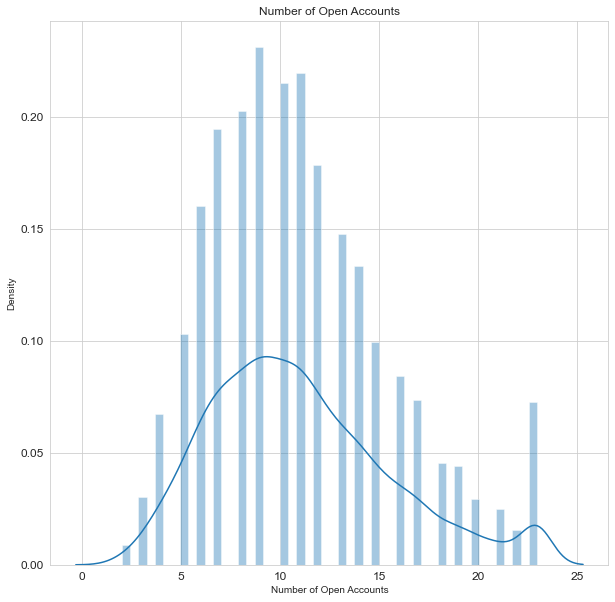

The skewness is  0.6733546244862935


E:\Anaconda_main\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


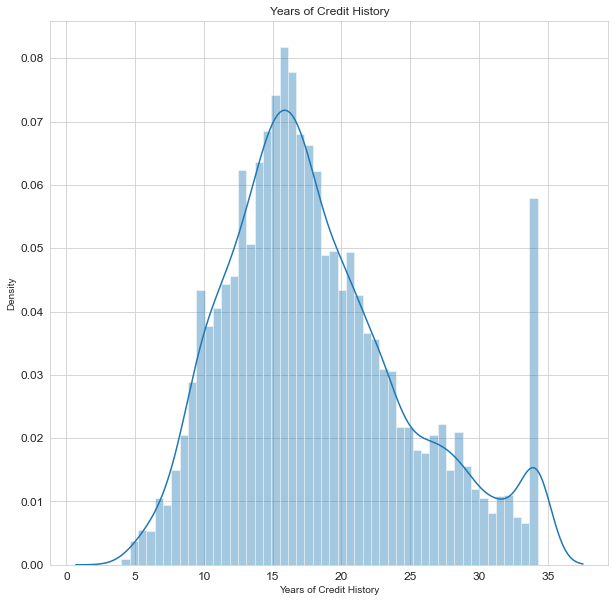

The skewness is  0.6460234149596031


E:\Anaconda_main\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


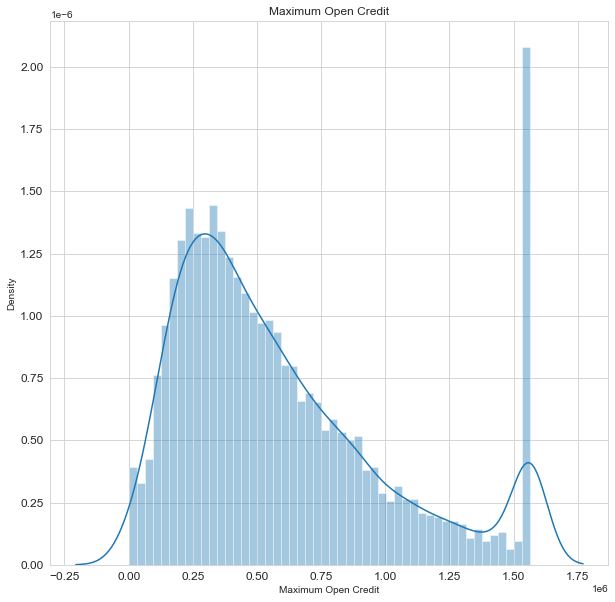

The skewness is  0.9900784663443797


E:\Anaconda_main\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


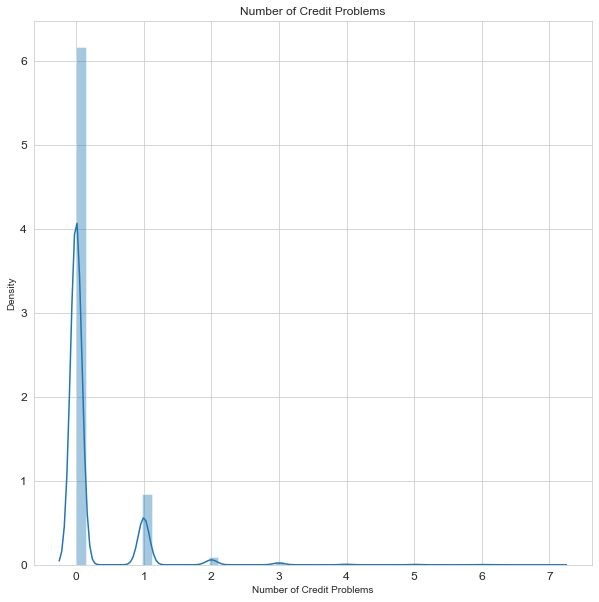

The skewness is  4.563332353698451


E:\Anaconda_main\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


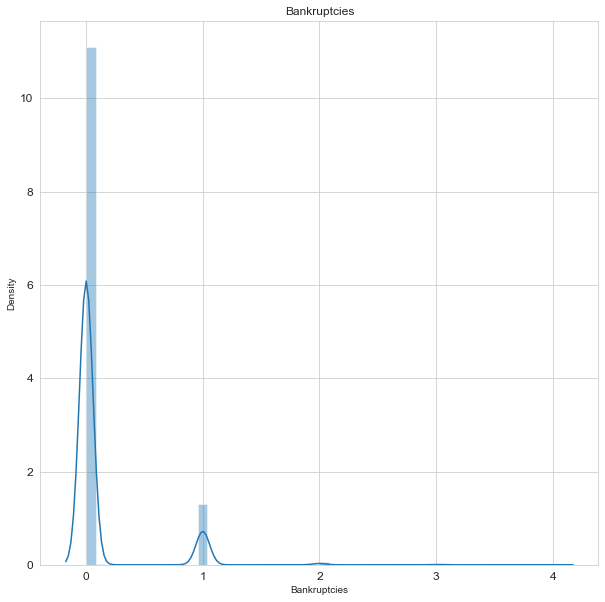

The skewness is  3.2653217613078365


E:\Anaconda_main\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


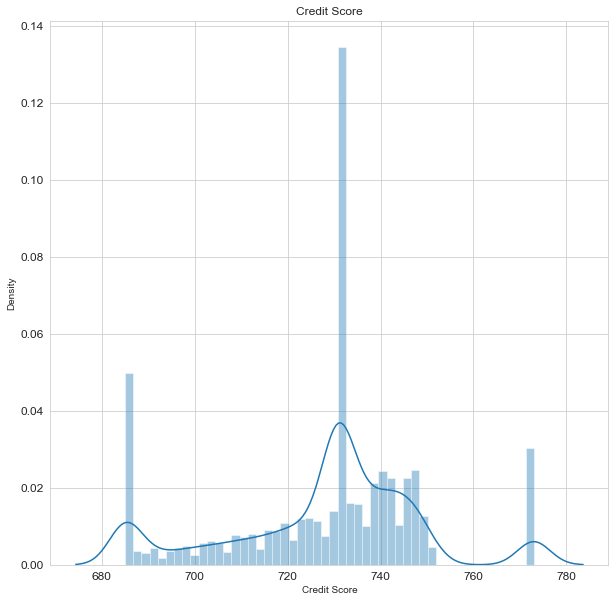

The skewness is  -0.3603825377873085


E:\Anaconda_main\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


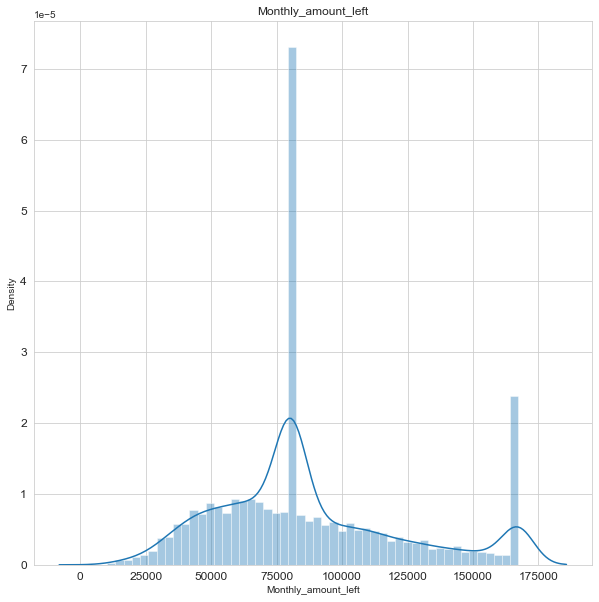

The skewness is  0.7304459954041863


E:\Anaconda_main\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


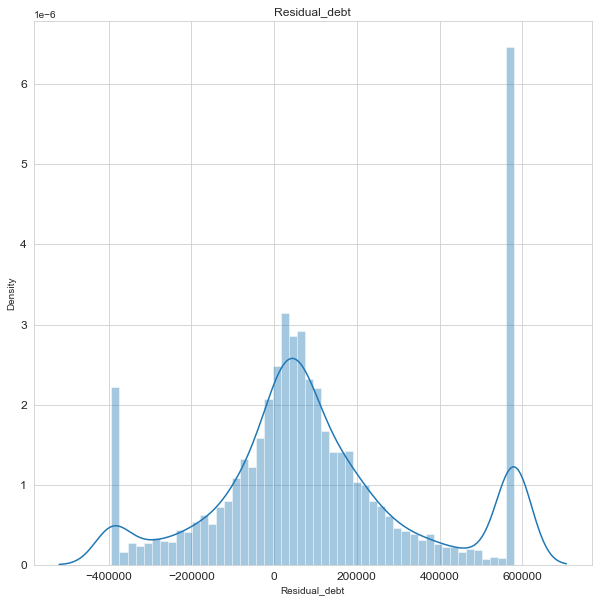

The skewness is  0.3543030298252548


In [133]:
# The impact on the distribution of the numerical features can be visualised

for fea in tr_num:
    plt.figure(figsize=(10,10))
    sns.set_style('whitegrid')
    sns.distplot(X_tr[fea], kde=True, bins= 50)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(fea)
    plt.show()
    print("The skewness is ", skew(X_tr[fea]))
    

Years in current job


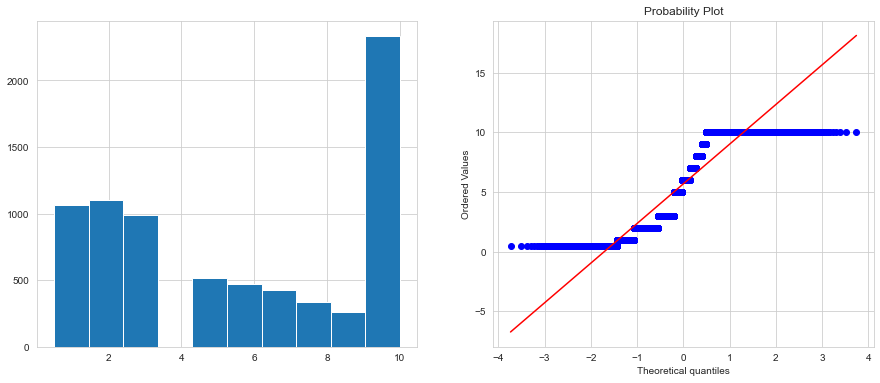

Tax Liens


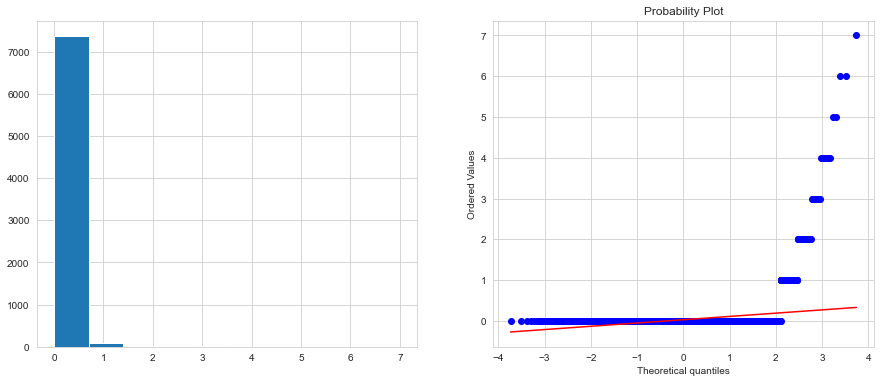

Number of Open Accounts


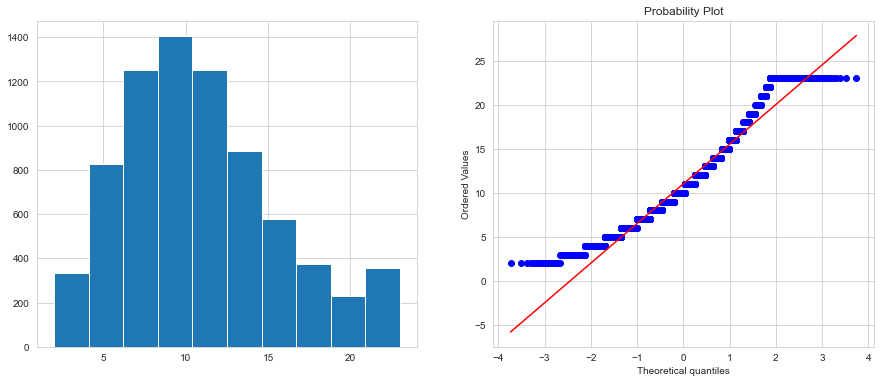

Years of Credit History


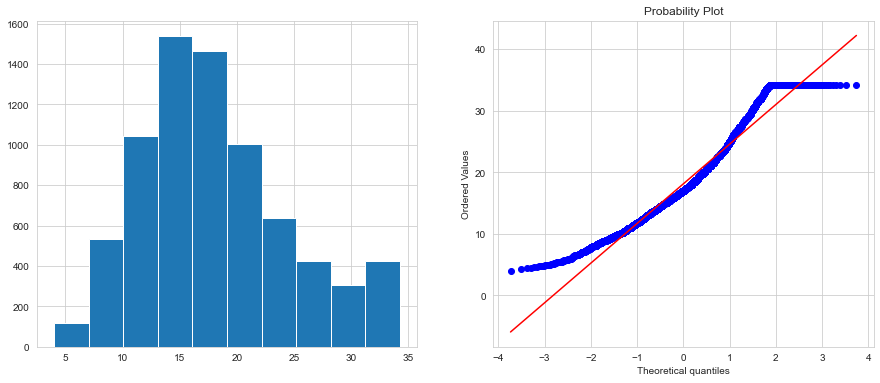

Maximum Open Credit


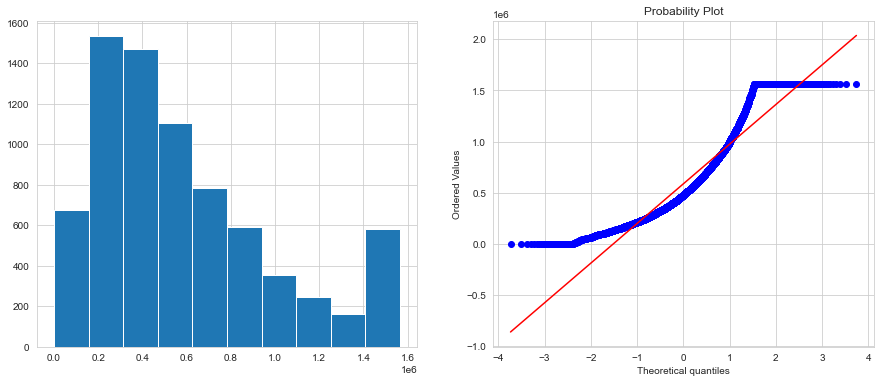

Number of Credit Problems


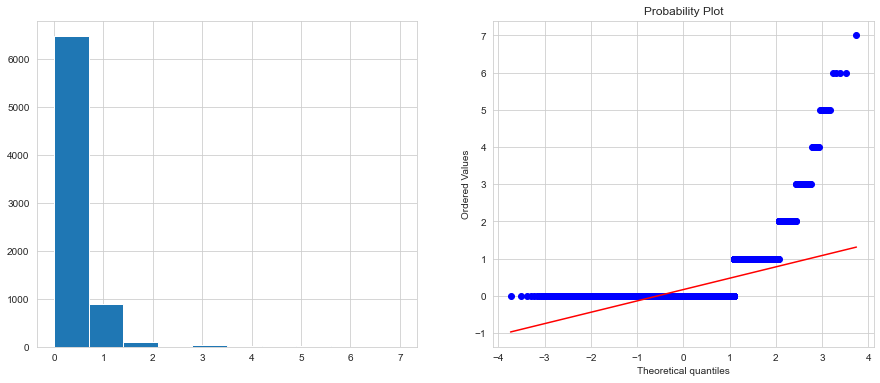

Bankruptcies


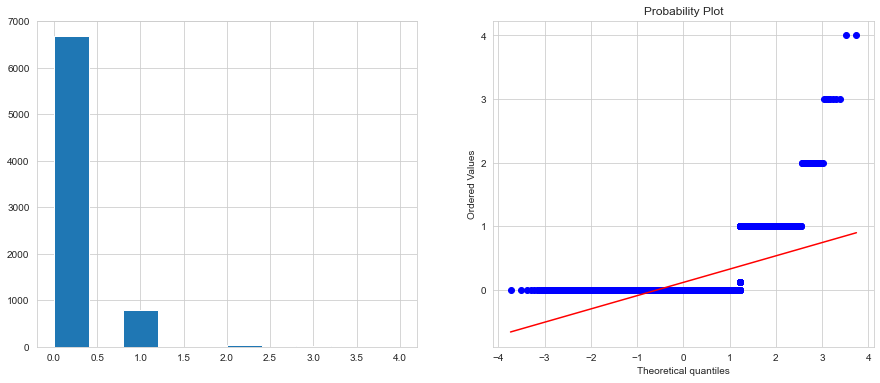

Credit Score


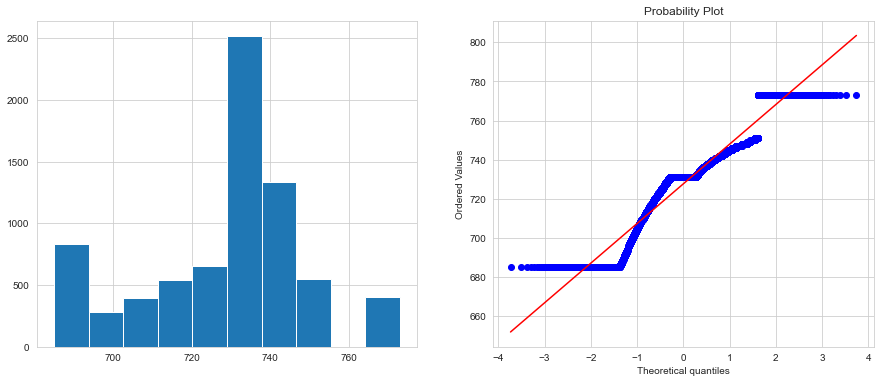

Monthly_amount_left


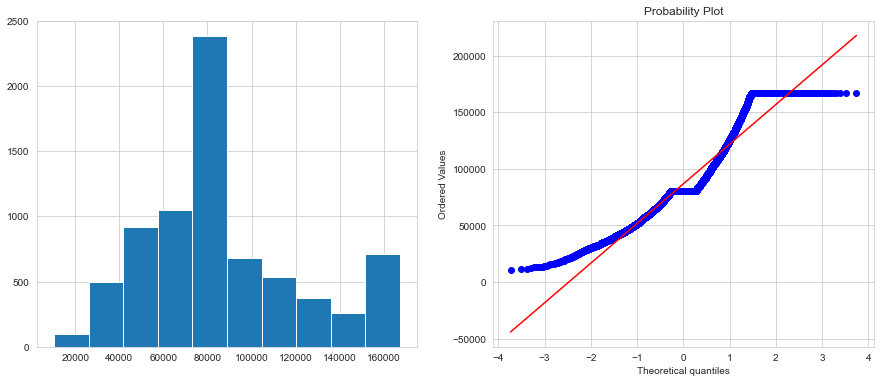

Residual_debt


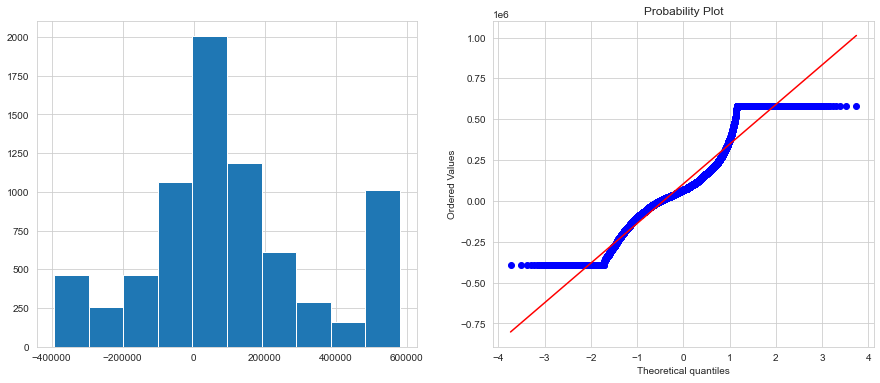

In [41]:
for fea in tr_num:
    print(fea)
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    X_tr[fea].hist()
    plt.subplot(1, 2, 2)
    stats.probplot(X_tr[fea], dist="norm", plot=plt)
    plt.show()

In [42]:
tr_cat

['Home Ownership', 'Term', 'Purpose_label']

### Encoding categorical variables

In [134]:
df_train = pd.get_dummies(X_tr, columns = tr_cat, drop_first= True)
df_test = pd.get_dummies(X_ts, columns = tr_cat, drop_first= True)

In [135]:
print(df_test.shape, df_train.shape, y_tr.shape)

(2500, 18) (7500, 18) (7500,)


### Our final dataset is "df_train" for the training data , y_tr for target variable and "df_test" for the test data

### Feature scaling on full training and test data

In [136]:
ct_sc = ColumnTransformer([('scaler', StandardScaler(), tr_num)], remainder='passthrough')

In [137]:
df_train_sc = ct_sc.fit_transform(df_train)

In [47]:
df_test_sc = ct_sc.transform(df_test)

### SMOTE : First oversample the entire training data i.e df_train, and then check CV score

In [138]:
from collections import Counter
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold

In [140]:
cls_xgb = XGBClassifier()
cls_rf  = RandomForestClassifier()
cls_cb  = CatBoostClassifier()


In [141]:
oversample = SMOTE()

In [142]:
df_train_sm, y_tr_sm = oversample.fit_resample(df_train_sc, y_tr)

In [143]:
print(Counter(y_tr), Counter(y_tr_sm))

Counter({0: 5387, 1: 2113}) Counter({0: 5387, 1: 5387})


## Model implementation
We consider three models for training purpose i.e XGBoost, CATBoost and RandomForest

In [144]:
XGB = cls_xgb.fit(df_train_sm,y_tr_sm)

E:\Anaconda_main\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:28:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [145]:
RF = cls_rf.fit(df_train_sm, y_tr_sm)


In [146]:
CB = cls_cb.fit(df_train_sm, y_tr_sm)

Learning rate set to 0.028429
0:	learn: 0.6781927	total: 597ms	remaining: 9m 56s
1:	learn: 0.6638502	total: 621ms	remaining: 5m 10s
2:	learn: 0.6518697	total: 642ms	remaining: 3m 33s
3:	learn: 0.6420023	total: 661ms	remaining: 2m 44s
4:	learn: 0.6297669	total: 752ms	remaining: 2m 29s
5:	learn: 0.6199435	total: 769ms	remaining: 2m 7s
6:	learn: 0.6107939	total: 872ms	remaining: 2m 3s
7:	learn: 0.6026861	total: 899ms	remaining: 1m 51s
8:	learn: 0.5964216	total: 924ms	remaining: 1m 41s
9:	learn: 0.5896064	total: 951ms	remaining: 1m 34s
10:	learn: 0.5850707	total: 975ms	remaining: 1m 27s
11:	learn: 0.5805234	total: 995ms	remaining: 1m 21s
12:	learn: 0.5756930	total: 1.01s	remaining: 1m 16s
13:	learn: 0.5730248	total: 1.03s	remaining: 1m 12s
14:	learn: 0.5710094	total: 1.05s	remaining: 1m 9s
15:	learn: 0.5665884	total: 1.08s	remaining: 1m 6s
16:	learn: 0.5620621	total: 1.12s	remaining: 1m 4s
17:	learn: 0.5581744	total: 1.14s	remaining: 1m 2s
18:	learn: 0.5551944	total: 1.17s	remaining: 1m
19

### Cross-validation check

In [147]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5)

cv_score_rf =  cross_val_score(RF, df_train_sm, y_tr_sm, scoring = "f1", cv= kfold)
print(cv_score_rf.mean())

0.7443481552906113


In [148]:
cv_score_xgb =  cross_val_score(XGB, df_train_sm, y_tr_sm, scoring= "f1", cv= kfold)
print("XGBoost mean CV score ", cv_score_xgb.mean())

E:\Anaconda_main\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:30:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


E:\Anaconda_main\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:30:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


E:\Anaconda_main\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:30:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


E:\Anaconda_main\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:30:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


E:\Anaconda_main\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:30:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost mean CV score  0.6825096447445794


In [149]:
cv_score_cb =  cross_val_score(CB, df_train_sm, y_tr_sm, scoring = "f1", cv= kfold)
print("CatBoost mean CV score ", cv_score_cb.mean())

Learning rate set to 0.025845
0:	learn: 0.6792327	total: 117ms	remaining: 1m 56s
1:	learn: 0.6672911	total: 138ms	remaining: 1m 8s
2:	learn: 0.6558963	total: 154ms	remaining: 51.3s
3:	learn: 0.6458632	total: 180ms	remaining: 44.9s
4:	learn: 0.6353427	total: 207ms	remaining: 41.1s
5:	learn: 0.6256018	total: 233ms	remaining: 38.6s
6:	learn: 0.6169605	total: 265ms	remaining: 37.6s
7:	learn: 0.6085618	total: 307ms	remaining: 38.1s
8:	learn: 0.6031791	total: 332ms	remaining: 36.5s
9:	learn: 0.5960355	total: 362ms	remaining: 35.8s
10:	learn: 0.5909589	total: 397ms	remaining: 35.7s
11:	learn: 0.5848282	total: 427ms	remaining: 35.1s
12:	learn: 0.5799540	total: 457ms	remaining: 34.7s
13:	learn: 0.5768583	total: 483ms	remaining: 34s
14:	learn: 0.5745959	total: 514ms	remaining: 33.7s
15:	learn: 0.5700994	total: 530ms	remaining: 32.6s
16:	learn: 0.5678904	total: 622ms	remaining: 35.9s
17:	learn: 0.5641522	total: 646ms	remaining: 35.2s
18:	learn: 0.5606841	total: 671ms	remaining: 34.7s
19:	learn: 0

## Predictions on main test dataset i.e df_test_sc
Since, this is a Kaggle project where multiple submissions are allowed, we are already aware of the the different final scores with different submissions. The idea here is to first train the entire training data and make predictions on the given testset, and the other task is to first make train-test split of the training data, check for accuracies and then make predictions on the final testset.

In [150]:
Y_predicted_RF = RF.predict(df_test_sc)
Y_predicted_CB = CB.predict(df_test_sc)
Y_predicted_XGB = XGB.predict(df_test_sc)

In [176]:
Df_pred_rf = pd.DataFrame.from_dict({"Id": Id , "Credit Default": Y_predicted_RF})
Df_pred_rf["Credit Default"].value_counts()

0    2002
1     498
Name: Credit Default, dtype: int64

In [186]:
Df_pred_rf = pd.DataFrame.from_dict({"Id": Id , "Credit Default": Y_predicted_RF})
Df_pred_rf["Credit Default"].value_counts()

0    2002
1     498
Name: Credit Default, dtype: int64

In [183]:
Df_pred_cb = pd.DataFrame.from_dict({"Id": Id , "Credit Default": Y_predicted_CB})
Df_pred_cb["Credit Default"].value_counts()

0    2007
1     493
Name: Credit Default, dtype: int64

In [519]:
DF_pred_xgb.to_csv("y_pred_main_XGB.csv", index = False)

In [182]:
Df_pred_rf.to_csv("Trial_RF.csv", index = False)

In [185]:
Df_pred_cb.to_csv("Trial_CB.csv", index = False)

## Train test split on given training data
This time we repeat the above steps on the split data of the original training set

In [63]:
X_train, X_test, y_train, y_test = train_test_split(df_train, y_tr, test_size = 0.2, random_state=0)


In [64]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(6000, 18) (6000,) (1500, 18) (1500,)


After train-test split we have X_train, X_test, y_train, y_test

### Feature scaling after train-test split

In [154]:
X_train_sc = ct_sc.fit_transform(X_train)
X_test_sc = ct_sc.transform(X_test)

In [155]:
print(len(X_train_sc), len(X_test_sc), len(y_train), len(y_test))

6000 1500 6000 1500


###  SMOTE : This time we oversample only the training data obtained after splitting df_train

In [156]:
oversample = SMOTE()
X_sm, y_sm = oversample.fit_resample(X_train_sc, y_train)

In [157]:
print(Counter(y_train), Counter(y_sm))

Counter({0: 4346, 1: 1654}) Counter({0: 4346, 1: 4346})


## Model evalution with confusion matrix

In [158]:
cls_xgb = XGBClassifier()
cls_cb  = CatBoostClassifier()
cls_rf  = RandomForestClassifier()

In [159]:
model_CB = cls_cb.fit(X_sm, y_sm)

Learning rate set to 0.025938
0:	learn: 0.6816585	total: 89ms	remaining: 1m 28s
1:	learn: 0.6700801	total: 108ms	remaining: 53.8s
2:	learn: 0.6571877	total: 123ms	remaining: 41s
3:	learn: 0.6481391	total: 138ms	remaining: 34.4s
4:	learn: 0.6375505	total: 150ms	remaining: 29.9s
5:	learn: 0.6284347	total: 165ms	remaining: 27.3s
6:	learn: 0.6206629	total: 177ms	remaining: 25.1s
7:	learn: 0.6130835	total: 192ms	remaining: 23.8s
8:	learn: 0.6068633	total: 206ms	remaining: 22.7s
9:	learn: 0.6000337	total: 227ms	remaining: 22.5s
10:	learn: 0.5955794	total: 250ms	remaining: 22.4s
11:	learn: 0.5902763	total: 270ms	remaining: 22.2s
12:	learn: 0.5855033	total: 290ms	remaining: 22s
13:	learn: 0.5806116	total: 310ms	remaining: 21.8s
14:	learn: 0.5771079	total: 334ms	remaining: 21.9s
15:	learn: 0.5730988	total: 350ms	remaining: 21.5s
16:	learn: 0.5693643	total: 366ms	remaining: 21.2s
17:	learn: 0.5653945	total: 386ms	remaining: 21.1s
18:	learn: 0.5623113	total: 407ms	remaining: 21s
19:	learn: 0.5600

In [160]:
model_RF = cls_rf.fit(X_sm, y_sm)

In [161]:
model_XGB = cls_xgb.fit(X_sm, y_sm)

E:\Anaconda_main\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:40:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### Predictions on the dummy test set obtained after splitting i.e X_test_sc
First, we test our model on the test set obtained through splitting the original training data

In [162]:
y_pred_CB = model_CB.predict(X_test_sc)
y_pred_XGB = model_XGB.predict(X_test_sc)
y_pred_RF = model_RF.predict(X_test_sc)

In [163]:
print("Actual test data ", Counter(y_test))

Actual test data  Counter({0: 1041, 1: 459})


In [164]:
print("For CatBoost ", Counter(y_pred_CB), "For RandomForest ", Counter(y_pred_XGB), "For XGBoost ", Counter(y_pred_RF))

For CatBoost  Counter({0: 1217, 1: 283}) For RandomForest  Counter({0: 1191, 1: 309}) For XGBoost  Counter({0: 1180, 1: 320})


In [165]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score

conf_matrx_RF = confusion_matrix(y_test, y_pred_RF)

class_report_RF = classification_report(y_test, y_pred_RF, labels=[1,0])

print(conf_matrx_RF)
print("Classification report \n", class_report_RF)
print("f_1 score is ", f1_score(y_test, y_pred_RF))
print("Accuracy score is ", accuracy_score(y_test, y_pred_RF))

[[914 127]
 [266 193]]
Classification report 
               precision    recall  f1-score   support

           1       0.60      0.42      0.50       459
           0       0.77      0.88      0.82      1041

    accuracy                           0.74      1500
   macro avg       0.69      0.65      0.66      1500
weighted avg       0.72      0.74      0.72      1500

f_1 score is  0.4955070603337613
Accuracy score is  0.738


In [166]:
conf_matrx_CB = confusion_matrix(y_test, y_pred_CB)

class_report_CB = classification_report(y_test, y_pred_CB, labels=[1,0])

print(conf_matrx_CB)
print("Classification report \n", class_report_CB)
print(f1_score(y_test, y_pred_CB))
print("Accuracy score is ", accuracy_score(y_test, y_pred_CB))

[[942  99]
 [275 184]]
Classification report 
               precision    recall  f1-score   support

           1       0.65      0.40      0.50       459
           0       0.77      0.90      0.83      1041

    accuracy                           0.75      1500
   macro avg       0.71      0.65      0.67      1500
weighted avg       0.74      0.75      0.73      1500

0.49595687331536387
Accuracy score is  0.7506666666666667


In [167]:
conf_matrx_XGB = confusion_matrix(y_test, y_pred_XGB)

class_report_XGB = classification_report(y_test, y_pred_XGB, labels=[1,0])

print(conf_matrx_XGB)
print("Classification report \n", class_report_XGB)
print(f1_score(y_test, y_pred_XGB))
print("Accuracy score is ", accuracy_score(y_test, y_pred_XGB))

[[914 127]
 [277 182]]
Classification report 
               precision    recall  f1-score   support

           1       0.59      0.40      0.47       459
           0       0.77      0.88      0.82      1041

    accuracy                           0.73      1500
   macro avg       0.68      0.64      0.65      1500
weighted avg       0.71      0.73      0.71      1500

0.4739583333333333
Accuracy score is  0.7306666666666667


## Predictions on actual test data i.e df_test_sc

In [168]:
y_predicted_RF = model_RF.predict(df_test_sc)
y_predicted_XGB = model_XGB.predict(df_test_sc)
y_predicted_CB = model_CB.predict(df_test_sc)

In [169]:
df_pred_xgb = pd.DataFrame.from_dict({"Id": Id , "Credit Default": y_predicted_XGB})
df_pred_xgb["Credit Default"].value_counts()

1    2257
0     243
Name: Credit Default, dtype: int64

In [171]:
df_pred_rf = pd.DataFrame.from_dict({"Id": Id , "Credit Default": y_predicted_RF})
df_pred_rf["Credit Default"].value_counts()

0    1861
1     639
Name: Credit Default, dtype: int64

In [170]:
df_pred_cb = pd.DataFrame.from_dict({"Id": Id , "Credit Default": y_predicted_CB})
df_pred_cb["Credit Default"].value_counts()

1    1872
0     628
Name: Credit Default, dtype: int64

In [496]:
df_pred_xgb.to_csv("y_predicted_XGB.csv", index = False)

df_pred_cb.to_csv("y_predicted_CB.csv", index = False)


In [163]:
df_pred_rf.to_csv("y_predicted_RF(NEW).csv", index = False)

In [166]:
Y_pred_rf = model_rf.predict(X_test_sca)

In [167]:
Y_pred_cb = model_cb.predict(X_test_sca)

In [254]:
Y_pred_xgb = model_xgb.predict(X_test_sca)

In [255]:
df_pred_xgb =  pd.DataFrame.from_dict({"Id": Id , "Credit Default": Y_pred_xgb})
df_pred_xgb["Credit Default"].value_counts()

0    2042
1     458
Name: Credit Default, dtype: int64

In [170]:
df_pred_cb =  pd.DataFrame.from_dict({"Id": Id , "Credit Default": Y_pred_cb})
df_pred_cb["Credit Default"].value_counts()

0    2196
1     304
Name: Credit Default, dtype: int64

In [171]:
df_pred_rf =  pd.DataFrame.from_dict({"Id": Id , "Credit Default": Y_pred_rf})
df_pred_rf["Credit Default"].value_counts()

0    2218
1     282
Name: Credit Default, dtype: int64

In [172]:
df_pred_cb.to_csv("Credit_Default_Predictions_CB.csv", index = False)
df_pred_rf.to_csv("Credit_Default_Predictions_RF.csv", index = False)
df_pred_xgb.to_csv("Credit_Default_Predictions_XGB.csv", index = False)